# Grid-Map Visualisation of TD-OPF Results

This notebook generates geographic grid-map figures that overlay
conductor temperatures and load-shedding markers on top of
air-temperature heatmaps for European country networks.

**Contents**
1. Imports & configuration
2. Single-country grid maps (ES, FR, IT)
3. Cross-border grid maps (FR↔IT, FR↔ES, FR↔GB, ES↔PT, ES↔FR)
4. Standalone colourbar figures
5. Test / debug sandbox

## 1. Imports & Configuration

In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

cur_dir = os.path.dirname(os.path.abspath(os.getcwd()))
par_dir = os.path.dirname(cur_dir)
sys.path.append(os.path.join(os.getcwd(), ".."))

from TDOPF_eur import *
from data_config import *
from utils.plot_utils import *

## 2. Single-Country Grid Maps

Generate grid-map PDFs for Spain, France, and Italy under the Iter-OPF
solver for July heatwave hours (12:00–15:00) across projected years
2026, 2028, and 2030.

In [2]:
TDPF_solver = 'td_seg_derate_iter_2'
fut_year_list = [2026, 2028, 2030]
heatwave_year_list = [2024]
heatwave_index = 0

load_rate = 1.01
storage_state = 0.8
thermal_limit = 90

for country_code in ['ES', 'FR', 'IT']:
    network, _ = load_network_EU(country_code, RATIO)
    n_bus = network.buses.shape[0]

    csv_path = (
        cur_dir
        + f'/models/{country_code}/{country_code}_{n_bus}_bus'
        + f'_renewable_True_heatwave_True_storage_True_{storage_state}'
        + f'_load_growth_True_{load_rate}_max_temp_{thermal_limit}'
        + f'_model_analysis.csv'
    )
    df = pd.read_csv(csv_path)

    for hour in [12, 13, 14, 15]:
        for fut_year in fut_year_list:
            sub_df = df[
                (df['TDPF_solver'] == TDPF_solver)
                & (df['fut_heatwave_year'] == fut_year)
            ]
            valid = (
                (sub_df['fut_heatwave_month'] == 7)
                & (sub_df['fut_heatwave_hour'] == hour)
                & (sub_df['solver_status'] == 1)
            )

            for fut_date in sub_df.loc[valid, 'fut_heatwave_date'].unique():
                sub2 = sub_df[sub_df['fut_heatwave_date'] == fut_date]
                fut_fmt = datetime.strptime(
                    fut_date, '%Y-%m-%d %H:%M:%S'
                ).strftime('%Y-%m-%d %H:%M:%S')

                for hw_year in heatwave_year_list:
                    hw_valid = sub2['his_heatwave_year'] == hw_year
                    for his_date in sub2.loc[hw_valid, 'his_heatwave_date'].unique()[heatwave_index:heatwave_index + 1]:
                        his_fmt = datetime.strptime(
                            his_date, '%Y-%m-%d'
                        ).strftime('%Y-%m-%d %H:%M:%S')

                        # Load weather data
                        weather_path = (
                            cur_dir
                            + f'/models/{country_code}/simu_data'
                            + f'/future_weather_data_based_on_historical'
                            + f'_hot_event_{hw_year}_{heatwave_index}.nc'
                        )
                        weather_cutout = xr.open_dataset(weather_path)
                        weather_cutout = weather_cutout.sel(time=fut_fmt)
                        temperature = weather_cutout['temperature'].data - TK

                        # Load OPF result
                        base_id = f'{country_code}_{n_bus}_{TDPF_solver}_{fut_fmt}_{his_fmt}'
                        para_id = f'storage_{storage_state}_load_growth_{load_rate}_thermal_{thermal_limit}'
                        expr_id = f'{base_id}_{para_id}_results.npy'
                        result = np.load(
                            cur_dir + f'/models/{country_code}/ppc/{fut_fmt}/{expr_id}',
                            allow_pickle=True,
                        ).item()

                        # Save grid map
                        grid_dir = (
                            cur_dir
                            + f'/models/grid_map/{country_code}'
                            + f'/soc_{storage_state}_load_{load_rate}'
                            + f'_thermal{thermal_limit}'
                        )
                        os.makedirs(grid_dir, exist_ok=True)
                        save_path = (
                            grid_dir
                            + f'/{country_code}_{TDPF_solver}'
                            + f'_{fut_fmt}_{his_fmt}.pdf'
                        )
                        network_grid_vis(
                            result, network, weather_cutout,
                            temperature, save_path=save_path,
                        )

Loading EU network from: /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/vis/../data/EU/networks/base_s_75_elec.nc


INFO:pypsa.io:Imported network base_s_75_elec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


## 3. Cross-Border Grid Maps

Generate grid-map PDFs for cross-border interconnected networks,
highlighting load shedding in the primary (first) country.

In [3]:
cross_border_pairs = [
    ['FR', 'IT'], ['FR', 'ES'], ['FR', 'GB'],
    ['ES', 'PT'], ['ES', 'FR'],
]

for country_code in cross_border_pairs:
    network, _ = load_network_EU(country_code, RATIO)
    n_bus = network.buses.shape[0]

    csv_path = (
        cur_dir
        + f'/models/{country_code}/{country_code}_{n_bus}_bus'
        + f'_renewable_True_heatwave_True_storage_True_{storage_state}'
        + f'_load_growth_True_{load_rate}_max_temp_90'
        + f'_sensitivity_analysis.csv'
    )
    df = pd.read_csv(csv_path)

    for TDPF_solver in ['td_seg_derate_iter_2']:
        for fut_year in [2026, 2028, 2030]:
            sub_df = df[
                (df['TDPF_solver'] == TDPF_solver)
                & (df['fut_heatwave_year'] == fut_year)
                & (df['solver_status'] == 1)
            ]
            valid = (
                (sub_df['fut_heatwave_month'] == 7)
                & (sub_df['fut_heatwave_hour'] == 13)
                & (sub_df['solver_status'] == 1)
            )

            for fut_date in sub_df.loc[valid, 'fut_heatwave_date'].unique():
                sub2 = sub_df[sub_df['fut_heatwave_date'] == fut_date]
                fut_fmt = datetime.strptime(
                    fut_date, '%Y-%m-%d %H:%M:%S'
                ).strftime('%Y-%m-%d %H:%M:%S')

                for hw_year in heatwave_year_list:
                    hw_valid = sub2['his_heatwave_year'] == hw_year
                    for his_date in sub2.loc[hw_valid, 'his_heatwave_date'].unique()[heatwave_index:heatwave_index + 1]:
                        his_fmt = datetime.strptime(
                            his_date, '%Y-%m-%d'
                        ).strftime('%Y-%m-%d %H:%M:%S')

                        # Load weather data
                        weather_path = (
                            cur_dir
                            + f'/models/{country_code}/simu_data'
                            + f'/future_weather_data_based_on_historical'
                            + f'_hot_event_{hw_year}_{heatwave_index}.nc'
                        )
                        weather_cutout = xr.open_dataset(weather_path)
                        weather_cutout = weather_cutout.sel(time=fut_fmt)
                        temperature = weather_cutout['temperature'].data - TK

                        # Load OPF result
                        base_id = f'{list(country_code)}_{n_bus}_{TDPF_solver}_{fut_fmt}_{his_fmt}'
                        para_id = f'storage_{storage_state}_load_growth_{load_rate}_thermal_90'
                        expr_id = f'{base_id}_{para_id}_results.npy'
                        ppc_path = cur_dir + f'/models/{list(country_code)}/ppc/{fut_fmt}'
                        results = np.load(
                            os.path.join(ppc_path, expr_id),
                            allow_pickle=True,
                        ).item()

                        # Save grid map
                        grid_dir = cur_dir + f'/models/grid_map/{country_code}'
                        os.makedirs(grid_dir, exist_ok=True)
                        save_path = (
                            grid_dir
                            + f'/{country_code}_{TDPF_solver}'
                            + f'_{fut_fmt}_{his_fmt}.pdf'
                        )
                        network_grid_vis(
                            results, network, weather_cutout,
                            temperature, country_code[0], save_path,
                        )

Loading EU network from: /Users/liangenming/Desktop/Code/Power-System-Evaluation/HeatAnalysis/vis/../data/EU/networks/base_s_75_elec.nc


INFO:pypsa.io:Imported network base_s_75_elec.nc has buses, carriers, generators, lines, links, loads, storage_units, stores


## 4. Standalone Colourbar Figures

Export discrete colourbars for line temperature and air temperature,
used as legends in the grid-map figures.

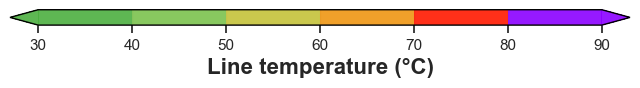

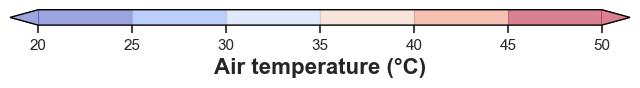

In [4]:
# Line-temperature colourbar (thermal danger palette)
line_cmap = line_thermal_cmap_subtle_danger(N=6)
cbar, fig = create_discrete_temperature_colorbar(
    cmap=line_cmap, num_levels=6, vmin=30, vmax=90,
    alpha=0.9, label='Line temperature (°C)',
    extend='both', figsize=[8, 0.20],
)
plt.savefig(
    cur_dir + '/models/color_bar_line_temp.pdf', bbox_inches='tight',
)

# Air-temperature colourbar (coolwarm)
cbar, fig = create_discrete_temperature_colorbar(
    cmap=plt.cm.coolwarm, num_levels=6, vmin=20, vmax=50,
    alpha=0.5, label='Air temperature (°C)',
    extend='both', figsize=[8, 0.20],
)
plt.savefig(
    cur_dir + '/models/color_bar_temperature.pdf', bbox_inches='tight',
)

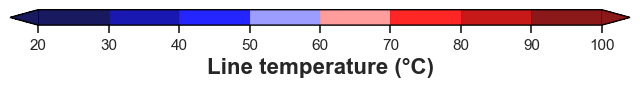

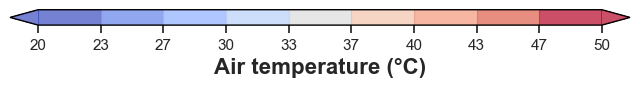

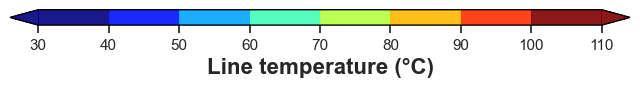

In [6]:
# Additional colourbar variants (seismic / jet)
seimic_cmap = seismic_no_white(skip_width=0.08, N=256)

cbar, fig = create_discrete_temperature_colorbar(
    cmap=seimic_cmap, num_levels=8, vmin=20, vmax=100,
    alpha=0.9, label='Line temperature (°C)',
    extend='both', figsize=[8, 0.20],
)

cbar, fig = create_discrete_temperature_colorbar(
    cmap=plt.cm.coolwarm, num_levels=9, vmin=20, vmax=50,
    alpha=0.7, label='Air temperature (°C)',
    extend='both', figsize=[8, 0.20],
)

cbar, fig = create_discrete_temperature_colorbar(
    cmap=plt.cm.jet, num_levels=8, vmin=30, vmax=110,
    alpha=0.9, label='Line temperature (°C)',
    extend='both', figsize=[8, 0.20],
)